In [1]:
import os
import re
import time
import math
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification, AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [4]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_sample_data = manager.list()
new_sample_labels = manager.list()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [5]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [6]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [7]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [8]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [9]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [10]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [11]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [12]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BULDING DATASET

In [13]:
class ClfDataset(Dataset):
    def __init__(self, data, labels, tokenizer, label2id):
        # Initialize dataset with data, tokenizer, and label mappings
        self.data = data
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.maxlength = sequence_length  # Maximum token length for input sequences
        self.all_labels_num = len(label2id)  # Total number of labels
        self.pair_wise_sampled = None  # Tracks sampling status of label pairs
        self.gt_labels = labels  # Ground truth labels in one-hot format
        self.all_labeled_mask = None  # Indicates whether all labels of a sample have been queried
        self.init()  # Initializes sampling and label mask states

    def init(self):
        # Initialize sampled pairs and mask for all data
        self.pair_wise_sampled = torch.ones(len(self.data), self.all_labels_num)
        self.all_labeled_mask = torch.zeros(len(self.data))  # Initially, no data is fully labeled

    def get_label_Cardinality(self):
        # Compute label cardinality, representing average positive labels per sample in the labeled pool
        labed_cnt = torch.sum(self.all_labeled_mask)  # Total number of samples fully labeled
        all_labed_pos_label_cnt = torch.sum(self.all_labeled_mask.unsqueeze(-1) * self.gt_labels)
        return all_labed_pos_label_cnt / labed_cnt  # Average number of positive labels per fully labeled sample

    def update_data(self, query_example_indices, query_label_indices=None, init_time=False):
        # Update dataset with new labeled data points and labels after each query cycle
        if query_label_indices is not None:
            ones = torch.ones(self.all_labels_num)
            for example_idx, label_idx in zip(query_example_indices, query_label_indices):
                # Access individual data and update based on queried label
                one_data = self.__getitem__(example_idx)
                one_label = one_data[1][label_idx]
                if one_label == 0:
                    # Set pair-wise sampled state for newly queried labels
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                else:
                    self.pair_wise_sampled[example_idx][label_idx] = 1
                
                # Update all_labeled_mask if all labels for a sample are queried
                if torch.sum(ones - self.pair_wise_sampled[example_idx]) == 0:
                    self.all_labeled_mask[example_idx] = 1
        else:
            # Mark all labels as queried for each example if only examples are specified
            for example_idx in query_example_indices:
                ones = torch.ones(self.all_labels_num)
                self.pair_wise_sampled[example_idx] = ones
                self.all_labeled_mask[example_idx] = 1

    def get_labeled_set(self):
        # Return list of indices for samples that have been fully labeled
        labeled_set = []
        for idx, mask in enumerate(self.all_labeled_mask):
            if mask != 0:
                labeled_set.append(idx)
        return labeled_set

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx] 
        labels = self.gt_labels[idx]

        # Tokenize the raw text and apply padding/truncation to reach maxlength
        encoding = self.tokenizer(
            item,
            padding='max_length',
            truncation=True,
            max_length=self.maxlength,
            return_tensors="pt"
        )

        # Extract tokenized fields
        input_ids = encoding['input_ids'].squeeze(0)  # Remove batch dimension
        input_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))
        input_mask = encoding['attention_mask'].squeeze(0)

        text_inputs = [input_ids, input_type_ids, input_mask]
        sampler_loss_weight = self.pair_wise_sampled[idx]  # Weight for active learning sample selection

        # Return inputs for model: tokenized text, labels, sample index, sampling weights, labeling status
        inputs_list = [text_inputs, labels, idx, sampler_loss_weight, self.all_labeled_mask[idx]]
        return inputs_list

In [14]:
def load_data(label2id):
    tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
    
    train_dataset = ClfDataset(
        data=train_data['Tweet'].values,
        labels=train_data[train_data.columns[1:]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    val_dataset = ClfDataset(
        data=val_data['Tweet'].values,
        labels=val_data[val_data.columns[1:]].values,
        tokenizer=tokenizer,
        label2id=label2id,
    )
    
    return train_dataset, val_dataset, len(train_data), len(val_data)

def load_label():
    label_freq_desc = [['HS', 1], ['Abusive', 1], ['HS_Individual', 1], ['HS_Group', 1], ['HS_Religion',1], ['HS_Race', 1], ['HS_Physical', 1], ['HS_Gender', 1], ['HS_Other', 1], ['HS_Weak', 1], ['HS_Moderate', 1], ['HS_Strong', 1]]
    label_weight = [x[1] for x in label_freq_desc]
    label_index = [x[0] for x in label_freq_desc]
    labels = label_index
    label2id = {j: i for i, j in enumerate(labels)}
    print('label num', len(labels))
    return len(labels), label2id

def label2list(label):
    print(label)
    outputs = [[] for _ in range(label.shape[0])]
    x,y = np.where(label==1)
    for xx,yy in zip(x,y):
        outputs[xx].append(yy)
    return outputs

# DEFINE THE MODEL

In [15]:
class IndoBERT_Backbone(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Backbone, self).__init__()
        self.label_num = label_num
        self.encoder = IndoBERT_Encoder(label_num)
        model_config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
        self.clf = nn.Linear(model_config.hidden_size, label_num)
        nn.init.xavier_uniform_(self.clf.weight)

    def forward(self, inputs):
        encoder_out = self.encoder(inputs)
        out = self.clf(encoder_out)
        return out, encoder_out

class IndoBERT_Encoder(nn.Module):
    def __init__(self, label_num):
        super(IndoBERT_Encoder, self).__init__()
        self.label_num = label_num
        self.encoder = BertModel.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=self.label_num,
        )
        
        self.encoder_init()

    def encoder_init(self):
        all_layers = ['embeddings', 'layer.0', 'layer.1', 'layer.2', 'layer.3', 'layer.4', 'layer.5', 'layer.6',
                      'layer.7', 'layer.8', 'layer.9', 'layer.10', 'layer.11', 'pooler']
        unfreeze_layers = all_layers[7:]
        for name, param in self.encoder.named_parameters():
            param.requires_grad = False
            for ele in unfreeze_layers:
                if ele in name:
                    param.requires_grad = True
                    break

    def forward(self, inputs):
        # Ensure each component in inputs is a tensor
        input_ids = torch.tensor(inputs[0]) if not isinstance(inputs[0], torch.Tensor) else inputs[0]
        token_type_ids = torch.tensor(inputs[1]) if not isinstance(inputs[1], torch.Tensor) else inputs[1]
        attention_mask = torch.tensor(inputs[2]) if not isinstance(inputs[2], torch.Tensor) else inputs[2]
        
        input_ids = input_ids.view(-1, input_ids.size(-1))  # Ensuring batch_size, sequence_length
        token_type_ids = token_type_ids.view(input_ids.size(0), -1)  # Reshaping to [batch_size, sequence_length]
        attention_mask = attention_mask.view(-1, attention_mask.size(-1))
        
        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
        )
        cls_output = outputs.pooler_output
        return cls_output

In [16]:
class MLP_VAE(nn.Module):
    def __init__(self, hidden_size, device):
        super(MLP_VAE, self).__init__()
        self.device = device
        self.label_num = 12
        self.cl_neg_mode = 1
        self.proto_size = 256
        self.hidden_size = hidden_size
        
        # Initial fully connected layer to project input to higher-dimensional space for each label
        self.fc0 = nn.Linear(self.hidden_size, 12 * 256)
        self.fc1 = nn.Linear(256, self.proto_size)  # Dimensionality reduction for prototypes

        # Adjust the number of label representations based on contrastive learning mode
        if self.cl_neg_mode == 0:
            cl_label_num = self.label_num  # Standard label number
        elif self.cl_neg_mode == 1:
            cl_label_num = self.label_num + 1  # Add one for negative prototype handling
            self.ins_neg_cnt = torch.zeros(1).to(device)
        elif self.cl_neg_mode == 2:
            cl_label_num = self.label_num * 2  # Double for positive and negative prototypes
            self.ins_neg_cnt = torch.zeros(self.label_num).to(device)
        self.cl_label_num = cl_label_num

        # Register buffer for label prototypes, aligned with CoMAL's prototype-based sampling
        self.register_buffer("prototypes", torch.zeros(self.cl_label_num, self.proto_size))
        self.ins_pos_cnt = torch.zeros(self.label_num).to(device)  # Track count of positive instances

        # Decoder and final aggregation layers
        self.fc3 = nn.Linear(self.proto_size, 256)
        self.agg = nn.Linear(self.label_num * 256, self.hidden_size)
        self.clf = nn.Linear(self.hidden_size, self.label_num)  # Classification layer

    def get_protos(self):
        return self.prototypes  # Return the prototypes for external use

    def reparameterize(self, mu, logvar):
        # VAE reparameterization trick for latent space sampling
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def reset_proto(self):
        # Reset prototype and count buffers
        self.ins_pos_cnt *= 0
        self.ins_neg_cnt *= 0
        self.prototypes *= 0

    def forward(self, x, labels=None, weights=None):
        # Ensure prototypes and other buffers are on the same device as the input
        device = x.device
        self.prototypes = self.prototypes.to(device)
        self.ins_pos_cnt = self.ins_pos_cnt.to(device)
        if self.cl_neg_mode in [1, 2]:
            self.ins_neg_cnt = self.ins_neg_cnt.to(device)
            
        # Project input into sub-representations per label
        sub_rep_ori = self.fc0(x)
        sr_shape = sub_rep_ori.shape
        sub_rep_ori = sub_rep_ori.view(sr_shape[0], self.label_num, -1)  # Split per label

        # Further reduction to prototype size and decoding step
        sub_rep = self.fc1(sub_rep_ori)
        dec_sub_rep = self.fc3(sub_rep)

        dist_1 = None
        sub_rep_norm = F.normalize(sub_rep.data, dim=-1)  # Normalize for distance calculations

        if labels is not None and weights is not None:
            # Generate masks for positive and negative samples
            pos_mask = labels * weights
            neg_mask = (1 - labels) * weights
            pos_mask = pos_mask.unsqueeze(-1)
            neg_mask = neg_mask.unsqueeze(-1)

            # Update prototypes based on positive and negative samples
            feat = torch.sum(sub_rep_norm * pos_mask, dim=0)
            self.prototypes[:self.label_num] = self.prototypes[:self.label_num] * self.ins_pos_cnt.unsqueeze(-1) + feat

            # Handle different contrastive learning modes
            if self.cl_neg_mode == 2:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                self.prototypes[self.label_num:] = self.prototypes[self.label_num:] * self.ins_neg_cnt.unsqueeze(-1) + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask.squeeze(-1), dim=0)
            elif self.cl_neg_mode == 1:
                feat_neg = torch.sum(sub_rep_norm * neg_mask, dim=0)
                feat_neg = torch.sum(feat_neg, dim=0)
                self.prototypes[-1] = self.prototypes[-1] * self.ins_neg_cnt + feat_neg
                self.ins_neg_cnt += torch.sum(neg_mask)
            
            # Update positive instance counts and normalize prototypes
            self.ins_pos_cnt += torch.sum(pos_mask.squeeze(-1), dim=0)
            self.prototypes = F.normalize(self.prototypes, p=2, dim=-1)

        # Calculate distances between sub-representations and prototypes
        if self.cl_neg_mode == 2:
            dist_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[:self.label_num]])
            dist_neg_1 = torch.einsum('bld,ld->bl', [sub_rep_norm, self.prototypes[self.label_num:]])
            dist_1 = torch.cat([dist_1, dist_neg_1], dim=1)  # Combine distances for positive and negative prototypes
        elif self.cl_neg_mode == 0 or self.cl_neg_mode == 1:
            dist_1 = sub_rep_norm @ self.prototypes.T  # Standard matrix multiplication for distance calculation

        # Decode and classify reconstructed input
        concat_sub_rep = dec_sub_rep.contiguous().view(dec_sub_rep.shape[0], -1)
        recon_x = self.agg(concat_sub_rep)
        recon_x_clf = self.clf(recon_x)

        return recon_x, sub_rep, recon_x_clf, dist_1  # Return reconstruction, sub-representation, classification, and distances

In [17]:
def get_cl_labels(labels, label_num, weight, cl_neg_mode=1):
    cl_labels = torch.zeros_like(labels, dtype=torch.long)
    cl_labels.fill_(label_num)
    example_idx, label_idx = torch.where(labels>=0.5)
    cl_labels[example_idx, label_idx] = label_idx #.float()
    cl_labels = cl_labels * weight + label_num * (1 - weight)
    if cl_neg_mode == 2:
        example_idx, label_idx = torch.where(labels < 0.5)
        cl_neg_labels = label_idx + label_num
        cl_labels[example_idx, label_idx] = cl_neg_labels.float()
        cl_labels = cl_labels * weight + 2 * label_num * (1 - weight)
    cl_labels = cl_labels.to(torch.int)
    return cl_labels

def get_cl_mask(cl_labels, label_num, batch_size, cl_neg_mode=1):
    mask = torch.eq(cl_labels[:batch_size], cl_labels.T).float()
    if cl_neg_mode == 0:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 1:
        neg_idx, _ = torch.where(cl_labels[:batch_size] > label_num)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    elif cl_neg_mode == 2:
        neg_idx, _ = torch.where(cl_labels[:batch_size] >= label_num * 2)
        neg_mask = torch.ones_like(mask)
        neg_mask[neg_idx] = 0
        neg_mask[:, neg_idx] = 0
        mask *= neg_mask
    else:
        neg_mask = torch.ones_like(mask)
    return mask, neg_mask

# DEFINE LOSSES

In [18]:
class SupConLoss(nn.Module):
    """Following Supervised Contrastive Learning:
        https://arxiv.org/pdf/2004.11362.pdf."""

    def __init__(self, temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.temperature = temperature
        self.base_temperature = base_temperature

    def forward(self, features, mask, neg_mask=None, batch_size=-1, device=None, other_features=None):
        if mask is not None:
            # SupCon loss (Partial Label Mode)
            mask = mask.float().detach()
            # compute logits
            if other_features is None:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], features.T),
                    self.temperature)
            else:
                anchor_dot_contrast = torch.div(
                    torch.matmul(features[:batch_size], other_features.T),
                    self.temperature)

            # for numerical stability
            logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
            logits = anchor_dot_contrast - logits_max.detach()

            # mask-out self-contrast cases
            if neg_mask is None:
                logits_mask = torch.ones_like(mask)
            else:
                logits_mask = torch.scatter(
                    neg_mask,
                    1,
                    torch.arange(batch_size).view(-1, 1).to(device),
                    0
                )
            mask = mask * logits_mask

            # compute log_prob
            exp_logits = torch.exp(logits) * logits_mask
            log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True) + 1e-12)
            # compute mean of log-likelihood over positive
            mean_log_prob_pos = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-12)
            # loss
            loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
            loss = loss.mean()
        else:
            q = features[:batch_size]
            k = features[batch_size:batch_size * 2]
            queue = features[batch_size * 2:]
            l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
            # negative logits: NxK
            l_neg = torch.einsum('nc,kc->nk', [q, queue])
            # logits: Nx(1+K)
            logits = torch.cat([l_pos, l_neg], dim=1)

            # apply temperature
            logits /= self.temperature

            # labels: positive key indicators
            labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()
            loss = F.cross_entropy(logits, labels)

        return loss

# MODEL TRAINING AND TESTING

In [19]:
total_data = len(train_data) + len(val_data)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast

def train_total_sep2(dataloaders, trials, metrics, current_train_size, filename, label_num=-1, seed=42, total_patience=3):
    set_seed(seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    best_score = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }
    best_score2 = {
        'accuracy': 0,
        'f1_micro': 0,
        'f1_macro': 0
    }
    second_phase = False
    total_patience_cnt = 0
    models = {}

    # Initialize models and move to multiple GPUs
    models['backbone'] = IndoBERT_Backbone(label_num).to(device)
    models['vae_module'] = MLP_VAE(768, device).to(device)

    # Optimizers
    optim_backbone = optim.AdamW(models['backbone'].parameters(), lr=2e-5, weight_decay=0.01)
    optim_module = optim.AdamW(models['vae_module'].parameters(), lr=2e-5, weight_decay=0.01)

    # Mixed precision scaler
    scaler = GradScaler()

    # Loaders
    train_loader = dataloaders['labeled']
    val_loader = dataloaders['test']

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        models['vae_module'].reset_proto()

        # Set training or evaluation modes
        if second_phase:
            models['backbone'].eval()
        else:
            models['backbone'].train()
        models['vae_module'].train()

        total_loss = 0

        for data in train_loader:
            optim_backbone.zero_grad()
            optim_module.zero_grad()

            labels, idx, loss_weight, _ = [x.to(device) for x in data[1:]]
            input_ids, input_type_ids, input_mask = [x.to(device) for x in data[0]]
            inputs_list = [input_ids, input_type_ids, input_mask, None]

            loss = 0

            with autocast():
                clf_out, encoder_cls = models['backbone'](inputs_list)
    
                # VAE forward pass
                module_cls = encoder_cls.detach()
                recon_x, latent_rep, recon_x_clf, _ = models['vae_module'](module_cls, labels=labels, weights=loss_weight)
    
                # Contrastive loss
                cl_labels = get_cl_labels(labels, label_num, loss_weight).view(-1)
                cl_labels_total = cl_labels.unsqueeze(-1)
                proj_total = latent_rep.view(-1, latent_rep.shape[-1])
                proj_total = F.normalize(proj_total, dim=-1)
                batch_size = clf_out.shape[0] * label_num
                mask, neg_mask = get_cl_mask(cl_labels_total, label_num, batch_size)
    
                criterion_cl = SupConLoss()
                cl_loss = criterion_cl(proj_total, mask, neg_mask, batch_size, device)
    
                # Reconstruction and classification loss
                criterion_mse = nn.MSELoss()
                recon_mse_loss = criterion_mse(recon_x, module_cls)
                criterion_bce = nn.BCEWithLogitsLoss()
                recon_bce_loss = criterion_bce(recon_x_clf, labels.float())
    
                loss2 = cl_loss + recon_mse_loss + recon_bce_loss
    
                if not second_phase:
                    clf_loss = criterion_bce(clf_out, labels.float())
                    loss += clf_loss
    
                loss += loss2
    
            scaler.scale(loss).backward()
            total_loss += loss.item()

            if second_phase:
                scaler.step(optim_module)
            else:
                scaler.step(optim_module)
                scaler.step(optim_backbone)
            scaler.update()

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)

        # Evaluation phase
        # if second_phase:
        #     score = test(device, models, epoch, dataloaders, test_dual=True)

        #     if score["f1_micro"] >= best_score2['f1_micro']:
        #         total_patience_cnt = 0
        #         best_score2 = score

        #         torch.save(models['vae_module'].state_dict(), f"{filename}-p2-vae-{trials + 1}-{percentage}.pth")
        #     else:
        #         total_patience_cnt += 1
        #         if total_patience_cnt >= total_patience:
        #             break
        # else:
        score = test(device, models, epoch, dataloaders)

        if score["f1_micro"] >= best_score['f1_micro']:
            best_score = score
            # total_patience_cnt = 0

            torch.save(models['backbone'].state_dict(), f"{filename}-p1-backbone-{trials + 1}-{percentage}.pth")
            torch.save(models['vae_module'].state_dict(), f"{filename}-p1-vae-{trials + 1}-{percentage}.pth")
        # else:
        #     total_patience_cnt += 1
        #     if total_patience_cnt >= total_patience:
        #         total_patience_cnt = 0
        #         second_phase = True

        print(f"EPOCH {epoch} | LOSS: {total_loss / len(train_loader)} | ACCURACY: {score['accuracy'].round(4)} | F1 MACRO: {score['f1_macro'].round(4)} | F1 MICRO: {score['f1_micro'].round(4)}")

    duration = time.time() - start_time
    print(f"Training completed in {duration} s")

    metrics[0].append(current_train_size)
    metrics[1].append(best_score['accuracy'])
    metrics[2].append(best_score['f1_micro'])
    metrics[3].append(best_score['f1_macro'])

    print(f"Iteration {current_train_size}: ACCURACY {best_score['accuracy'].round(4)} | F1 MACRO {best_score['f1_macro'].round(4)} | F1 MICRO {best_score['f1_micro'].round(4)}")
    print(best_score['report'])

In [21]:
def test(device, models, epoch, dataloaders, test_dual=False, final_test=False):
    outputs_clf = [[], [], [], [], []]
    outputs_dis = [[], [], [], [], []]
    outputs_dual = [[], [], [], [], []]
    outputs_z = [[], [], [], [], []]
    
    for key in models.keys():
        models[key].eval()
        
    with torch.no_grad():
        for data in dataloaders['test']:
            input_ids, input_type_ids, input_mask = [x.to(device, non_blocking=True) for x in data[0]]
            labels = data[1].to(device)
            out = [input_ids, input_type_ids, input_mask, None]

            clf_out, encoder_cls = models['backbone'](out)
            outputs_clf = neaten_test_result(outputs_clf, clf_out, labels)
            
            _, _, recon_x_clf, _ = models['vae_module'](encoder_cls)
            outputs_dual = neaten_test_result(outputs_dual, recon_x_clf, labels)
            
    outputs_clf = concat_test_result(outputs_clf)

    result = {}
                                 
    if 'vae_module' in models.keys() and not final_test and test_dual:
        outputs_dual = concat_test_result(outputs_dual)
        true_labels_vae = outputs_dual[0]
        predicted_vae = []

        result['accuracy'] = hamming_accuracy(outputs_dual[0], outputs_dual[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_dual[0], outputs_dual[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_dual[0], outputs_dual[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_dual[0], 
            outputs_dual[4], 
            target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
            zero_division=0
        )
    else:
        result['accuracy'] = hamming_accuracy(outputs_clf[0], outputs_clf[4])
        result['precision'], result['recall'], result['f1_macro'], _ = precision_recall_fscore_support(
            outputs_clf[0], outputs_clf[4], zero_division=0, average='macro'
        )
        result['f1_micro'] = f1_score(outputs_clf[0], outputs_clf[4], zero_division=0, average='micro')
        result['report'] = classification_report(
            outputs_clf[0], 
            outputs_clf[4], 
            target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
            zero_division=0
        )

    return result

def concat_test_result(outputs):
    outputs[0] = np.concatenate(outputs[0], axis=0)
    outputs[1] = np.concatenate(outputs[1], axis=0)
    outputs[2] = np.concatenate(outputs[2], axis=0)
    outputs[3] = np.concatenate(outputs[3], axis=0)
    outputs[4] = np.concatenate(outputs[4], axis=0)
    return outputs

def neaten_test_result(outputs, logits, labels):
    labels = labels.data.cpu().numpy()
    prob, pred = torch.topk(logits, 4)
    prob = torch.sigmoid(prob).data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    logits = logits.data.cpu().numpy()
    pred_labels = np.zeros(logits.shape)
    pred_labels[logits >= 0.5] = 1
    outputs[0].append(labels)
    outputs[1].append(pred)
    outputs[2].append(prob)
    outputs[3].append(logits)
    outputs[4].append(pred_labels)
    
    return outputs

def hamming_accuracy(true_labels, pred_labels):
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    correct = (true_labels == pred_labels).sum(axis=1)  # Count correct labels for each instance
    total_labels = true_labels.shape[1]  # Number of labels per instance
    return np.mean(correct / total_labels)  # Average over all instances

# QUERY STRATEGY

In [22]:
def query_samples(filename, dataset, current_train_size, labeled_set, unlabeled_indices, num_labels, trials, sampling_dur, new_sample_data, new_sample_labels,
                  label_cardinality=None, labeled_subset=None, save_path=None, cl_neg_mode=1, n_samples=min_increment):
    device = torch.device('cuda')

    models = {}
    backbone = IndoBERT_Backbone(num_labels)
    vae = MLP_VAE(768, device)

    current_train_size = len(dataset.get_labeled_set())

    nearest_cp = current_train_size
    if nearest_cp not in checkpoints:
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    percentage = math.ceil(nearest_cp / total_data * 100)

    backbone.load_state_dict(torch.load(f"{filename}-p1-backbone-{trials+1}-{percentage}.pth"))
    models['backbone'] = backbone
    if os.path.exists(f'/kaggle/working/{filename}-p2-vae-{trials+1}-{percentage}.pth'):
        vae.load_state_dict(torch.load(f"{filename}-p2-vae-{trials+1}-{percentage}.pth"))
    else:
        vae.load_state_dict(torch.load(f"{filename}-p1-vae-{trials+1}-{percentage}.pth"))
    models['vae_module'] = vae

    # Wrap models with DataParallel for multi-GPU support
    for key in models.keys():
        models[key] = models[key].to(device)
        models[key].eval()

    start_time = time.time()

    # Initialize lists to store outputs used for sampling calculations
    predictions, sample_indices = [], []
    sample_weights = []
    backbone_predictions = []
    backbone_distances = []
    ground_truth_labels = []
    vae_predictions = []
    sub_representations = []

    # If training with the VAE module, initialize labeled data processing
    labeled_sub_representations = []
    labeled_distances = []
    labeled_ground_truths = []

    # Labeled DataLoader
    labeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )

    # Process labeled data to extract features and distances for sampling criteria
    for text_inputs, gt_label, idx, _, _ in labeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]
        labeled_ground_truths.extend(gt_label)

        with torch.no_grad():
            # Use backbone model to get encoded representations
            _, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])

            # If VAE module is present, obtain sub-representations and distances
            if 'vae_module' in models.keys():
                _, sub_representation, _, vae_distance = models['vae_module'](encoded_cls)
                sub_representation = sub_representation.cpu().data  # N, L, d
                vae_distance = vae_distance.cpu().data
                labeled_distances.extend(vae_distance)
                labeled_sub_representations.extend(F.normalize(sub_representation, dim=-1))  # Normalized for comparison

    # Stack outputs for further processing
    labeled_ground_truths = torch.stack(labeled_ground_truths)  # N, L
    labeled_sub_representations = torch.stack(labeled_sub_representations)  # N, L, d
    labeled_distances = torch.stack(labeled_distances)  # N, L+1

    # Compute self-prototype distances based on CoMAL's contrastive learning mode
    if cl_neg_mode == 1:
        labeled_prototype_distances = labeled_distances[:, :, :-1]  # Exclude last distance for prototype calculation
        labeled_prototype_distances = labeled_prototype_distances * torch.eye(num_labels)  # Keep only diagonal elements
        labeled_prototype_distances = torch.sum(labeled_prototype_distances, dim=-1)  # Sum along prototype axis
        positive_distances = labeled_prototype_distances * labeled_ground_truths  # Mask with ground truth labels
    elif cl_neg_mode == 2:
        # Split distances into positive and negative based on contrastive learning mode
        positive_distances, negative_distances = labeled_distances.chunk(2, dim=-1)
        positive_distances = positive_distances * labeled_ground_truths

    # Calculate max, min, and mean positive distances for uncertainty measurement
    max_positive_distances = torch.max(positive_distances, dim=0)[0]
    min_positive_distances = torch.min(positive_distances + (1 - labeled_ground_truths) * 2, dim=0)[0]
    mean_positive_distances = (max_positive_distances + min_positive_distances) / 2

    # DataLoader for unlabeled data to compute sampling scores
    unlabeled_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(unlabeled_indices)))
    )
    
    # Process unlabeled data to get sampling scores
    for text_inputs, labels, idx, loss_weight, _ in unlabeled_dataloader:
        input_ids, token_type_ids, attention_mask = [x.to(device) for x in text_inputs]

        with torch.no_grad():
            # Get predictions and encoded representations
            predictions, encoded_cls = models['backbone']([input_ids, token_type_ids, attention_mask, None])
            predictions = predictions.cpu().data
            backbone_predictions.extend(predictions)

            # If VAE module exists, get latent representations, reconstructions, and distances
            if 'vae_module' in models.keys():
                recon_x, latent_rep, recon_x_clf, vae_distance = models['vae_module'](encoded_cls)
                latent_rep = latent_rep.cpu().data
                vae_distance = vae_distance.cpu().data
                recon_x_clf = recon_x_clf.cpu().data
                vae_predictions.extend(recon_x_clf)
                backbone_distances.extend(vae_distance)
                sub_representations.extend(F.normalize(latent_rep, dim=-1))  # Normalized latent space representation
            else:
                vae_predictions.extend(predictions)

        # Append sample indices, loss weights, and ground truth labels for use in ranking
        sample_indices.extend(idx)
        sample_weights.extend(loss_weight)
        ground_truth_labels.extend(labels)

     # Convert lists to tensors for further computation
    sample_indices = torch.stack(sample_indices)
    sample_weights = torch.stack(sample_weights)
    ground_truth_labels = torch.stack(ground_truth_labels)

    # If VAE module is used, stack additional representations and save if needed
    if 'vae_module' in models.keys():
        sub_representations = torch.stack(sub_representations)

        # Stack and prepare distance matrix for final scoring
        distance_matrix = torch.stack(backbone_distances)

    # Convert predictions to probability and adjust masks for scoring
    backbone_predictions = torch.stack(backbone_predictions)
    probability_predictions = torch.sigmoid(backbone_predictions)
    unlabeled_mask = torch.ones_like(sample_weights)

    # Calculate uncertainty metrics and part scores for sampling
    sample_weights = sample_weights.view(-1)
    unlabeled_part, labeled_part = pred_part_stat(sample_weights, threshold=0.5)
    unlabeled_labelwise_indices = list(set(unlabeled_part // num_labels))
    unlabeled_labelwise_indices = torch.tensor(unlabeled_labelwise_indices)

    # Mask predictions based on positive distances
    positive_distance_mask = ((probability_predictions >= 0.5) * unlabeled_mask).float()
    if cl_neg_mode == 2:
        positive_prototype_distances, negative_prototype_distances = distance_matrix.chunk(2, dim=-1)
    elif cl_neg_mode == 0 or cl_neg_mode == 1:
        if cl_neg_mode == 0:
            positive_prototype_distances = distance_matrix
        elif cl_neg_mode == 1:
            positive_prototype_distances = distance_matrix[:, :, :-1]
        positive_prototype_distances = positive_prototype_distances * torch.eye(num_labels)
        positive_prototype_distances = torch.sum(positive_prototype_distances, dim=-1)

    # Compute scores based on uncertainty and diversity metrics
    prediction_mask = (positive_prototype_distances > mean_positive_distances).float()
    distance_count = torch.sum(prediction_mask, dim=-1)
    cardinality_difference = torch.abs(distance_count - label_cardinality)
    score_weight = positive_distance_mask * (positive_prototype_distances + 1) / 2

    # Create a mask for nonzero elements
    nonzero_mask = score_weight > 0

    # Sum only nonzero elements per row
    sum_nonzero = (score_weight * nonzero_mask).sum(dim=-1)
    
    # Count nonzero elements per row
    count_nonzero = nonzero_mask.sum(dim=-1)
    
    # Avoid division by zero (optional, but recommended)
    count_nonzero = count_nonzero.clamp(min=1)
    
    # Compute mean
    score_weight = sum_nonzero / count_nonzero
    adjusted_score = torch.pow(score_weight, 0.5) + torch.pow(cardinality_difference, 1 - 0.5)
    final_scores = adjusted_score.unsqueeze(-1)
    average_scores = torch.mean(final_scores, dim=-1).cpu().numpy()
    
    ranked_indices = np.argsort(average_scores)
    ranked_indices = ranked_indices[::-1]
    
    # Select top samples for annotation
    threshold = np.percentile(average_scores, 90)
    items_greater_than_threshold = average_scores[average_scores >= threshold]
    num_of_candidates = min(math.ceil(0.1 * len(average_scores)), len(items_greater_than_threshold))

    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        selected_indices = ranked_indices[:n_samples]
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        selected_indices = ranked_indices[:max(n_samples, num_of_candidates)]
    else:
        selected_indices = ranked_indices[:nearest_cp - current_train_size]
        
        temp = dataset.get_labeled_set()
        temp.extend([sample_indices[int(i)] for i in selected_indices])
        
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'HS': [y_train[i][0] for i in temp],
            'Abusive': [y_train[i][1] for i in temp],
            'HS_Individual': [y_train[i][2] for i in temp],
            'HS_Group': [y_train[i][3] for i in temp],
            'HS_Religion': [y_train[i][4] for i in temp],
            'HS_Race': [y_train[i][5] for i in temp],
            'HS_Physical': [y_train[i][6] for i in temp],
            'HS_Gender': [y_train[i][7] for i in temp],
            'HS_Other': [y_train[i][8] for i in temp],
            'HS_Weak': [y_train[i][9] for i in temp],
            'HS_Moderate': [y_train[i][10] for i in temp],
            'HS_Strong': [y_train[i][11] for i in temp],
        })

        acquired_data.to_csv(f'{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    for x in selected_indices:
        new_sample_data.append(sample_indices[int(x)])
    new_sample_labels = None
    
    end_time = time.time()
    duration = end_time - start_time

    print("Nearest checkpoint:", nearest_cp)
    print("Threshold:", threshold)
    print("Samples above threshold:", num_of_candidates)
    print("Acquired samples:", len(selected_indices))
    print(f"Sampling duration: {duration} seconds")  # Print or return the runtime if needed

    sampling_dur.append(duration)

def pred_part_stat(pred, threshold=0.0):
    part_1 = torch.where(pred >= threshold)[0]
    part_0 = torch.where(pred < threshold)[0]
    return part_0, part_1


# PLOT RESULT

In [23]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# MAIN LOOP

In [24]:
def active_learning(seed, i, init_size):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_sample_data = manager.list()
    new_sample_labels = manager.list()
    filename = f'hsd-comal-init-{init_size}'
    
    current_train_size = initial_train_size
    start_time = time.time()
    set_seed(seed)

    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    # Load label information and dataset
    label_num, label2id = load_label()
    train_dataset, val_dataset, num_train, num_test = load_data(label2id)
    
    # Shuffle and initialize labeled and unlabeled sets
    indices = list(range(num_train))
    random.shuffle(indices)
    labeled_set = indices[:initial_train_size]  # Random initial labeled set
    unlabeled_set = [x for x in indices if x not in labeled_set]  # Define the unlabeled set
    
    # Update dataset with initial labeled set
    train_dataset.update_data(labeled_set, init_time=True)
    
    # Prepare data loaders for labeled and test sets
    labeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(labeled_set)))
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True
    )
    unlabeled_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        sampler=SubsetRandomSampler(list(set(indices)))
    )

    models = {}

    while current_train_size < checkpoints[len(checkpoints) - 1]:
        dataloaders = {
            'labeled': labeled_loader,
            'test': val_loader
        }
    
        # Train model
        train_total_sep2(dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, filename, label_num, seed)
        
        query_set = list(set(unlabeled_set))
        # random.shuffle(query_set)
        # subset = query_set[:]
    
        # Query samples for next cycle, using appropriate selection strategy
        new_sample_data = manager.list()
        new_sample_labels = manager.list()
        query_samples(
            filename,
            train_dataset, 
            current_train_size,
            labeled_set,
            query_set, 
            label_num,
            i,
            sampling_dur,
            new_sample_data,
            new_sample_labels,
            train_dataset.get_label_Cardinality()
        )
        new_sample_data = list(new_sample_data)
        new_sample_labels = list(new_sample_labels)

        train_dataset.update_data(new_sample_data, None)
        labeled_set = train_dataset.get_labeled_set()
        unlabeled_set = [x for x in indices if x not in labeled_set]
    
        # Refresh data loader with new labeled set
        labeled_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
            sampler=SubsetRandomSampler(list(set(labeled_set)))
        )
        
        # Update current train size
        current_train_size = len(labeled_set)
        print("New train size:", current_train_size)
    
    # DataLoader dictionary to be used for training and testing
    dataloaders = {
        'labeled': labeled_loader,
        'test': val_loader
    }
    
    # Train last iteration
    train_total_sep2(dataloaders, i, (data_used, accuracies, f1_micros, f1_macros), current_train_size, filename, label_num, seed)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
        
    # Log results
    end_time = time.time()
    duration = end_time - start_time

    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")

    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    sampling_dur.insert(0, 0)
    
    results['Sampling Duration'] = sampling_dur
    
    results.to_csv(f'{filename}-results.csv', index=False)

## RUN 1

TRIAL 1
Random seed: 50
label num 12


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

EPOCH 1 | LOSS: 13.406359990437826 | ACCURACY: 0.8249 | F1 MACRO: 0.0021 | F1 MICRO: 0.0029
EPOCH 2 | LOSS: 12.902708053588867 | ACCURACY: 0.8274 | F1 MACRO: 0.0 | F1 MICRO: 0.0
EPOCH 3 | LOSS: 12.007404327392578 | ACCURACY: 0.8276 | F1 MACRO: 0.0003 | F1 MICRO: 0.0007
EPOCH 4 | LOSS: 11.605810165405273 | ACCURACY: 0.8318 | F1 MACRO: 0.027 | F1 MICRO: 0.0677
EPOCH 5 | LOSS: 10.900807698567709 | ACCURACY: 0.8322 | F1 MACRO: 0.0278 | F1 MICRO: 0.0701
EPOCH 6 | LOSS: 10.357880433400473 | ACCURACY: 0.8319 | F1 MACRO: 0.0247 | F1 MICRO: 0.0615
EPOCH 7 | LOSS: 9.653802712758383 | ACCURACY: 0.8328 | F1 MACRO: 0.0343 | F1 MICRO: 0.0829
EPOCH 8 | LOSS: 8.574780146280924 | ACCURACY: 0.8324 | F1 MACRO: 0.0608 | F1 MICRO: 0.132
EPOCH 9 | LOSS: 8.773163795471191 | ACCURACY: 0.8318 | F1 MACRO: 0.0913 | F1 MICRO: 0.1956
EPOCH 10 | LOSS: 8.549648443857828 | ACCURACY: 0.8335 | F1 MACRO: 0.0899 | F1 MICRO: 0.1922
Training completed in 126.44146847724915 s
Iteration 131: ACCURACY 0.8318 | F1 MACRO 0.0913

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 3.4311325788497924
Samples above threshold: 1041
Acquired samples: 1041
Sampling duration: 54.64311504364014 seconds
New train size: 1172


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 11.923710873252467 | ACCURACY: 0.8487 | F1 MACRO: 0.1518 | F1 MICRO: 0.3784
EPOCH 2 | LOSS: 8.772921762968364 | ACCURACY: 0.8694 | F1 MACRO: 0.2298 | F1 MICRO: 0.5075
EPOCH 3 | LOSS: 7.7362692230626156 | ACCURACY: 0.8778 | F1 MACRO: 0.2982 | F1 MICRO: 0.5047
EPOCH 4 | LOSS: 7.460273366225393 | ACCURACY: 0.8897 | F1 MACRO: 0.4049 | F1 MICRO: 0.629
EPOCH 5 | LOSS: 7.3178279023421435 | ACCURACY: 0.8894 | F1 MACRO: 0.4318 | F1 MICRO: 0.6362
EPOCH 6 | LOSS: 7.076147757078472 | ACCURACY: 0.8926 | F1 MACRO: 0.4867 | F1 MICRO: 0.6534
EPOCH 7 | LOSS: 6.929168299624794 | ACCURACY: 0.8962 | F1 MACRO: 0.5019 | F1 MICRO: 0.6631
EPOCH 8 | LOSS: 6.7901269762139576 | ACCURACY: 0.8917 | F1 MACRO: 0.5095 | F1 MICRO: 0.6693
EPOCH 9 | LOSS: 6.631005161686947 | ACCURACY: 0.8951 | F1 MACRO: 0.5158 | F1 MICRO: 0.6675
EPOCH 10 | LOSS: 6.549084312037418 | ACCURACY: 0.8943 | F1 MACRO: 0.5153 | F1 MICRO: 0.6476
Training completed in 172.6477916240692 s
Iteration 1172: ACCURACY 0.8917 | F1 MACRO 0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 3.386748790740967
Samples above threshold: 937
Acquired samples: 937
Sampling duration: 52.677730560302734 seconds
New train size: 2109
EPOCH 1 | LOSS: 10.517695152398312 | ACCURACY: 0.853 | F1 MACRO: 0.1719 | F1 MICRO: 0.456
EPOCH 2 | LOSS: 7.745611869927608 | ACCURACY: 0.8762 | F1 MACRO: 0.2993 | F1 MICRO: 0.5522
EPOCH 3 | LOSS: 7.3624419299038975 | ACCURACY: 0.8859 | F1 MACRO: 0.419 | F1 MICRO: 0.5933
EPOCH 4 | LOSS: 7.180834539008863 | ACCURACY: 0.8988 | F1 MACRO: 0.4968 | F1 MICRO: 0.6761
EPOCH 5 | LOSS: 7.00320528492783 | ACCURACY: 0.903 | F1 MACRO: 0.5277 | F1 MICRO: 0.6787
EPOCH 6 | LOSS: 6.824119322227709 | ACCURACY: 0.904 | F1 MACRO: 0.5535 | F1 MICRO: 0.7021
EPOCH 7 | LOSS: 6.6675935369549375 | ACCURACY: 0.9016 | F1 MACRO: 0.5574 | F1 MICRO: 0.6959
EPOCH 8 | LOSS: 6.518122297344786 | ACCURACY: 0.9029 | F1 MACRO: 0.5787 | F1 MICRO: 0.7166
EPOCH 9 | LOSS: 6.371604803836707 | ACCURACY: 0.9001 | F1 MACRO: 0.5845 | F1 MICRO: 0.7123
EPOCH 10 | L

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 2.859754943847656
Samples above threshold: 759
Acquired samples: 759
Sampling duration: 53.084075689315796 seconds
New train size: 3711
EPOCH 1 | LOSS: 9.278590950472601 | ACCURACY: 0.8627 | F1 MACRO: 0.2616 | F1 MICRO: 0.5454
EPOCH 2 | LOSS: 7.304957998209987 | ACCURACY: 0.893 | F1 MACRO: 0.397 | F1 MICRO: 0.624
EPOCH 3 | LOSS: 7.0933438087331835 | ACCURACY: 0.904 | F1 MACRO: 0.4813 | F1 MICRO: 0.6793
EPOCH 4 | LOSS: 6.894024232338214 | ACCURACY: 0.9074 | F1 MACRO: 0.5358 | F1 MICRO: 0.685
EPOCH 5 | LOSS: 6.731982855961241 | ACCURACY: 0.9076 | F1 MACRO: 0.5837 | F1 MICRO: 0.7325
EPOCH 6 | LOSS: 6.5538122160681365 | ACCURACY: 0.9113 | F1 MACRO: 0.5819 | F1 MICRO: 0.7225
EPOCH 7 | LOSS: 6.386614824163503 | ACCURACY: 0.9116 | F1 MACRO: 0.6319 | F1 MICRO: 0.7309
EPOCH 8 | LOSS: 6.251787900924683 | ACCURACY: 0.9134 | F1 MACRO: 0.6082 | F1 MICRO: 0.7193
EPOCH 9 | LOSS: 6.1452062705467485 | ACCURACY: 0.9125 | F1 MACRO: 0.6385 | F1 MICRO: 0.7358
EPOCH 10 | 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 2.572983503341675
Samples above threshold: 615
Acquired samples: 615
Sampling duration: 52.51754665374756 seconds
New train size: 5009
EPOCH 1 | LOSS: 8.84137677542771 | ACCURACY: 0.8829 | F1 MACRO: 0.3087 | F1 MICRO: 0.5464
EPOCH 2 | LOSS: 7.184820048416717 | ACCURACY: 0.9042 | F1 MACRO: 0.4872 | F1 MICRO: 0.6899
EPOCH 3 | LOSS: 6.937428401995309 | ACCURACY: 0.9104 | F1 MACRO: 0.5492 | F1 MICRO: 0.7031
EPOCH 4 | LOSS: 6.747436161282696 | ACCURACY: 0.9143 | F1 MACRO: 0.6086 | F1 MICRO: 0.7315
EPOCH 5 | LOSS: 6.592423167409776 | ACCURACY: 0.9168 | F1 MACRO: 0.6682 | F1 MICRO: 0.7571
EPOCH 6 | LOSS: 6.441721421253832 | ACCURACY: 0.9198 | F1 MACRO: 0.6732 | F1 MICRO: 0.7597
EPOCH 7 | LOSS: 6.306153055987781 | ACCURACY: 0.9195 | F1 MACRO: 0.6612 | F1 MICRO: 0.7438
EPOCH 8 | LOSS: 6.166660948644711 | ACCURACY: 0.9174 | F1 MACRO: 0.6664 | F1 MICRO: 0.7537
EPOCH 9 | LOSS: 6.080437708504593 | ACCURACY: 0.921 | F1 MACRO: 0.688 | F1 MICRO: 0.7593
EPOCH 10 | LO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 2.6539928913116455
Samples above threshold: 553
Acquired samples: 553
Sampling duration: 53.02898645401001 seconds
New train size: 5562


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.740524034390504 | ACCURACY: 0.888 | F1 MACRO: 0.3936 | F1 MICRO: 0.6179
EPOCH 2 | LOSS: 7.16746771472624 | ACCURACY: 0.9034 | F1 MACRO: 0.48 | F1 MICRO: 0.6843
EPOCH 3 | LOSS: 6.928372224171956 | ACCURACY: 0.911 | F1 MACRO: 0.5517 | F1 MICRO: 0.7018
EPOCH 4 | LOSS: 6.747773592499481 | ACCURACY: 0.9158 | F1 MACRO: 0.6038 | F1 MICRO: 0.72
EPOCH 5 | LOSS: 6.5779898687340745 | ACCURACY: 0.9198 | F1 MACRO: 0.6605 | F1 MICRO: 0.7541
EPOCH 6 | LOSS: 6.429768260868117 | ACCURACY: 0.9186 | F1 MACRO: 0.6485 | F1 MICRO: 0.7489
EPOCH 7 | LOSS: 6.287782225115546 | ACCURACY: 0.9203 | F1 MACRO: 0.6711 | F1 MICRO: 0.7512
EPOCH 8 | LOSS: 6.1698544107634445 | ACCURACY: 0.92 | F1 MACRO: 0.6735 | F1 MICRO: 0.7473
EPOCH 9 | LOSS: 6.071926714360029 | ACCURACY: 0.9201 | F1 MACRO: 0.6736 | F1 MICRO: 0.7544
EPOCH 10 | LOSS: 5.993304438974666 | ACCURACY: 0.9199 | F1 MACRO: 0.686 | F1 MICRO: 0.7611
Training completed in 283.3680329322815 s
Iteration 5562: ACCURACY 0.9199 | F1 MACRO 0.686 | F1 M

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.671244259884483 | ACCURACY: 0.8869 | F1 MACRO: 0.431 | F1 MICRO: 0.6513
EPOCH 2 | LOSS: 7.159648207614296 | ACCURACY: 0.9076 | F1 MACRO: 0.5096 | F1 MICRO: 0.6943
EPOCH 3 | LOSS: 6.909162034486469 | ACCURACY: 0.9154 | F1 MACRO: 0.5953 | F1 MICRO: 0.7361
EPOCH 4 | LOSS: 6.7212091496116235 | ACCURACY: 0.9177 | F1 MACRO: 0.6543 | F1 MICRO: 0.7502
EPOCH 5 | LOSS: 6.561719703674316 | ACCURACY: 0.9232 | F1 MACRO: 0.666 | F1 MICRO: 0.7604
EPOCH 6 | LOSS: 6.419132172433954 | ACCURACY: 0.9214 | F1 MACRO: 0.6602 | F1 MICRO: 0.7578
EPOCH 7 | LOSS: 6.27252755416067 | ACCURACY: 0.9187 | F1 MACRO: 0.6876 | F1 MICRO: 0.7676
EPOCH 8 | LOSS: 6.1528340640820955 | ACCURACY: 0.922 | F1 MACRO: 0.6886 | F1 MICRO: 0.7591
EPOCH 9 | LOSS: 6.061972296865362 | ACCURACY: 0.923 | F1 MACRO: 0.7029 | F1 MICRO: 0.7619
EPOCH 10 | LOSS: 5.991436205412212 | ACCURACY: 0.9197 | F1 MACRO: 0.6969 | F1 MICRO: 0.7662
Training completed in 295.9336738586426 s
Iteration 6060: ACCURACY 0.9187 | F1 MACRO 0.6876 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.498686612736096 | ACCURACY: 0.8926 | F1 MACRO: 0.4463 | F1 MICRO: 0.6589
EPOCH 2 | LOSS: 7.106723737716675 | ACCURACY: 0.9104 | F1 MACRO: 0.5478 | F1 MICRO: 0.6996
EPOCH 3 | LOSS: 6.876487432826649 | ACCURACY: 0.9168 | F1 MACRO: 0.5889 | F1 MICRO: 0.7381
EPOCH 4 | LOSS: 6.686771815473383 | ACCURACY: 0.9207 | F1 MACRO: 0.6567 | F1 MICRO: 0.7624
EPOCH 5 | LOSS: 6.540841009400108 | ACCURACY: 0.9188 | F1 MACRO: 0.6526 | F1 MICRO: 0.7429
EPOCH 6 | LOSS: 6.375408239798112 | ACCURACY: 0.9234 | F1 MACRO: 0.6713 | F1 MICRO: 0.7642
EPOCH 7 | LOSS: 6.25967654098164 | ACCURACY: 0.9224 | F1 MACRO: 0.6814 | F1 MICRO: 0.7681
EPOCH 8 | LOSS: 6.132386623729359 | ACCURACY: 0.9227 | F1 MACRO: 0.7 | F1 MICRO: 0.7757
EPOCH 9 | LOSS: 6.051296591758728 | ACCURACY: 0.9246 | F1 MACRO: 0.6922 | F1 MICRO: 0.7701
EPOCH 10 | LOSS: 5.976570038361983 | ACCURACY: 0.9222 | F1 MACRO: 0.6991 | F1 MICRO: 0.7644
Training completed in 319.9257528781891 s
Iteration 6980: ACCURACY 0.9227 | F1 MACRO 0.7 | F1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 7901
Threshold: 1.734200119972229
Samples above threshold: 356
Acquired samples: 356
Sampling duration: 52.91115975379944 seconds
New train size: 7336
EPOCH 1 | LOSS: 8.524684495511263 | ACCURACY: 0.9004 | F1 MACRO: 0.4578 | F1 MICRO: 0.6757
EPOCH 2 | LOSS: 7.099270575979482 | ACCURACY: 0.9116 | F1 MACRO: 0.5536 | F1 MICRO: 0.7033
EPOCH 3 | LOSS: 6.870627108864162 | ACCURACY: 0.9215 | F1 MACRO: 0.6481 | F1 MICRO: 0.7574
EPOCH 4 | LOSS: 6.678238043577775 | ACCURACY: 0.9207 | F1 MACRO: 0.6634 | F1 MICRO: 0.7451
EPOCH 5 | LOSS: 6.520435839113982 | ACCURACY: 0.9249 | F1 MACRO: 0.6786 | F1 MICRO: 0.7636
EPOCH 6 | LOSS: 6.37529467707095 | ACCURACY: 0.9231 | F1 MACRO: 0.6958 | F1 MICRO: 0.7749
EPOCH 7 | LOSS: 6.259783230657163 | ACCURACY: 0.9235 | F1 MACRO: 0.7034 | F1 MICRO: 0.7737
EPOCH 8 | LOSS: 6.154637751371964 | ACCURACY: 0.925 | F1 MACRO: 0.6958 | F1 MICRO: 0.7709
EPOCH 9 | LOSS: 6.053206688424815 | ACCURACY: 0.9238 | F1 MACRO: 0.6997 | F1 MICRO: 0.7651
EPOCH 10 | L

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.474996777375539 | ACCURACY: 0.8893 | F1 MACRO: 0.4072 | F1 MICRO: 0.5664
EPOCH 2 | LOSS: 7.096073043346405 | ACCURACY: 0.9136 | F1 MACRO: 0.5695 | F1 MICRO: 0.7185
EPOCH 3 | LOSS: 6.868171838919322 | ACCURACY: 0.9195 | F1 MACRO: 0.6447 | F1 MICRO: 0.7345
EPOCH 4 | LOSS: 6.6826841831207275 | ACCURACY: 0.9205 | F1 MACRO: 0.6395 | F1 MICRO: 0.7366
EPOCH 5 | LOSS: 6.526420303185781 | ACCURACY: 0.92 | F1 MACRO: 0.6598 | F1 MICRO: 0.7434
EPOCH 6 | LOSS: 6.392115847269694 | ACCURACY: 0.9255 | F1 MACRO: 0.7065 | F1 MICRO: 0.7754
EPOCH 7 | LOSS: 6.254160813490549 | ACCURACY: 0.9253 | F1 MACRO: 0.6982 | F1 MICRO: 0.7715
EPOCH 8 | LOSS: 6.155990195274353 | ACCURACY: 0.9248 | F1 MACRO: 0.6974 | F1 MICRO: 0.7701
EPOCH 9 | LOSS: 6.078133877118429 | ACCURACY: 0.9242 | F1 MACRO: 0.7013 | F1 MICRO: 0.7622
EPOCH 10 | LOSS: 6.016848075389862 | ACCURACY: 0.9249 | F1 MACRO: 0.7091 | F1 MICRO: 0.7734
Training completed in 337.01223158836365 s
Iteration 7656: ACCURACY 0.9255 | F1 MACRO 0.70

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 7901
Threshold: 1.6729764938354492
Samples above threshold: 288
Acquired samples: 245
Sampling duration: 52.64018130302429 seconds
New train size: 7901


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.45006921214442 | ACCURACY: 0.9026 | F1 MACRO: 0.4815 | F1 MICRO: 0.6682
EPOCH 2 | LOSS: 7.088971903247218 | ACCURACY: 0.9097 | F1 MACRO: 0.5315 | F1 MICRO: 0.6856
EPOCH 3 | LOSS: 6.836196268758466 | ACCURACY: 0.9198 | F1 MACRO: 0.6257 | F1 MICRO: 0.7423
EPOCH 4 | LOSS: 6.652670302698689 | ACCURACY: 0.9245 | F1 MACRO: 0.667 | F1 MICRO: 0.7558
EPOCH 5 | LOSS: 6.506387549061929 | ACCURACY: 0.9234 | F1 MACRO: 0.6734 | F1 MICRO: 0.7709
EPOCH 6 | LOSS: 6.364111504247112 | ACCURACY: 0.9234 | F1 MACRO: 0.6838 | F1 MICRO: 0.7702
EPOCH 7 | LOSS: 6.2465371508752146 | ACCURACY: 0.9246 | F1 MACRO: 0.7028 | F1 MICRO: 0.7795
EPOCH 8 | LOSS: 6.153520422597086 | ACCURACY: 0.9226 | F1 MACRO: 0.6823 | F1 MICRO: 0.755
EPOCH 9 | LOSS: 6.071052501278539 | ACCURACY: 0.922 | F1 MACRO: 0.6849 | F1 MICRO: 0.7626
EPOCH 10 | LOSS: 6.02509940824201 | ACCURACY: 0.9262 | F1 MACRO: 0.7064 | F1 MICRO: 0.7782
Training completed in 343.03045320510864 s
Iteration 7901: ACCURACY 0.9246 | F1 MACRO 0.7028 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.6019655466079712
Samples above threshold: 214
Acquired samples: 214
Sampling duration: 52.24249529838562 seconds
New train size: 8616


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.414822702054623 | ACCURACY: 0.9021 | F1 MACRO: 0.5043 | F1 MICRO: 0.6762
EPOCH 2 | LOSS: 7.053862550523546 | ACCURACY: 0.914 | F1 MACRO: 0.5527 | F1 MICRO: 0.7073
EPOCH 3 | LOSS: 6.824388221458152 | ACCURACY: 0.9216 | F1 MACRO: 0.6707 | F1 MICRO: 0.7632
EPOCH 4 | LOSS: 6.660393714904785 | ACCURACY: 0.9235 | F1 MACRO: 0.657 | F1 MICRO: 0.7586
EPOCH 5 | LOSS: 6.51396951675415 | ACCURACY: 0.9223 | F1 MACRO: 0.688 | F1 MICRO: 0.7732
EPOCH 6 | LOSS: 6.398373999419036 | ACCURACY: 0.9207 | F1 MACRO: 0.6962 | F1 MICRO: 0.7723
EPOCH 7 | LOSS: 6.284074603186713 | ACCURACY: 0.9232 | F1 MACRO: 0.7024 | F1 MICRO: 0.7727
EPOCH 8 | LOSS: 6.196625522330955 | ACCURACY: 0.9239 | F1 MACRO: 0.7052 | F1 MICRO: 0.7656
EPOCH 9 | LOSS: 6.1121889220343695 | ACCURACY: 0.924 | F1 MACRO: 0.6958 | F1 MICRO: 0.7712
EPOCH 10 | LOSS: 6.058596950107151 | ACCURACY: 0.9236 | F1 MACRO: 0.709 | F1 MICRO: 0.7754
Training completed in 359.8463087081909 s
Iteration 8616: ACCURACY 0.9236 | F1 MACRO 0.709 | F

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.5848047733306885
Samples above threshold: 192
Acquired samples: 200
Sampling duration: 52.66273236274719 seconds
New train size: 8816


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.40466334854347 | ACCURACY: 0.8987 | F1 MACRO: 0.4685 | F1 MICRO: 0.6382
EPOCH 2 | LOSS: 7.048470780469369 | ACCURACY: 0.9137 | F1 MACRO: 0.5787 | F1 MICRO: 0.7086
EPOCH 3 | LOSS: 6.826020095659339 | ACCURACY: 0.9206 | F1 MACRO: 0.6238 | F1 MICRO: 0.7381
EPOCH 4 | LOSS: 6.6652455744536026 | ACCURACY: 0.9248 | F1 MACRO: 0.6691 | F1 MICRO: 0.7653
EPOCH 5 | LOSS: 6.519945165385371 | ACCURACY: 0.9228 | F1 MACRO: 0.6645 | F1 MICRO: 0.7481
EPOCH 6 | LOSS: 6.404795992201653 | ACCURACY: 0.9255 | F1 MACRO: 0.6861 | F1 MICRO: 0.7727
EPOCH 7 | LOSS: 6.294213222420734 | ACCURACY: 0.9258 | F1 MACRO: 0.6899 | F1 MICRO: 0.7675
EPOCH 8 | LOSS: 6.209757566452026 | ACCURACY: 0.9257 | F1 MACRO: 0.703 | F1 MICRO: 0.7714
EPOCH 9 | LOSS: 6.122116289277008 | ACCURACY: 0.9257 | F1 MACRO: 0.694 | F1 MICRO: 0.7776
EPOCH 10 | LOSS: 6.067568906839343 | ACCURACY: 0.9248 | F1 MACRO: 0.7081 | F1 MICRO: 0.7767
Training completed in 367.25887155532837 s
Iteration 8816: ACCURACY 0.9257 | F1 MACRO 0.694

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.5687872171401978
Samples above threshold: 172
Acquired samples: 200
Sampling duration: 52.386351108551025 seconds
New train size: 9016
EPOCH 1 | LOSS: 8.39133735413247 | ACCURACY: 0.8999 | F1 MACRO: 0.45 | F1 MICRO: 0.6424
EPOCH 2 | LOSS: 7.048663950980978 | ACCURACY: 0.9153 | F1 MACRO: 0.5634 | F1 MICRO: 0.7121
EPOCH 3 | LOSS: 6.827248968976609 | ACCURACY: 0.9235 | F1 MACRO: 0.6466 | F1 MICRO: 0.7588
EPOCH 4 | LOSS: 6.656487147013347 | ACCURACY: 0.9239 | F1 MACRO: 0.6685 | F1 MICRO: 0.7665
EPOCH 5 | LOSS: 6.523922331789707 | ACCURACY: 0.9253 | F1 MACRO: 0.6952 | F1 MICRO: 0.7753
EPOCH 6 | LOSS: 6.407273454869047 | ACCURACY: 0.9257 | F1 MACRO: 0.6907 | F1 MICRO: 0.7667
EPOCH 7 | LOSS: 6.2881928572418 | ACCURACY: 0.9229 | F1 MACRO: 0.7029 | F1 MICRO: 0.7705
EPOCH 8 | LOSS: 6.20293338924435 | ACCURACY: 0.9215 | F1 MACRO: 0.6886 | F1 MICRO: 0.759
EPOCH 9 | LOSS: 6.123818674831526 | ACCURACY: 0.9246 | F1 MACRO: 0.7018 | F1 MICRO: 0.7649
EPOCH 10 | LOSS

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.320603957669489 | ACCURACY: 0.9012 | F1 MACRO: 0.4762 | F1 MICRO: 0.6531
EPOCH 2 | LOSS: 7.013977132994553 | ACCURACY: 0.9151 | F1 MACRO: 0.5758 | F1 MICRO: 0.7266
EPOCH 3 | LOSS: 6.806008107086708 | ACCURACY: 0.9191 | F1 MACRO: 0.6565 | F1 MICRO: 0.7468
EPOCH 4 | LOSS: 6.658549284112865 | ACCURACY: 0.9237 | F1 MACRO: 0.6626 | F1 MICRO: 0.7588
EPOCH 5 | LOSS: 6.531050009563051 | ACCURACY: 0.9261 | F1 MACRO: 0.6881 | F1 MICRO: 0.7718
EPOCH 6 | LOSS: 6.422904039251393 | ACCURACY: 0.9244 | F1 MACRO: 0.6849 | F1 MICRO: 0.7582
EPOCH 7 | LOSS: 6.314373124878982 | ACCURACY: 0.9263 | F1 MACRO: 0.6925 | F1 MICRO: 0.774
EPOCH 8 | LOSS: 6.2158536417730925 | ACCURACY: 0.923 | F1 MACRO: 0.6913 | F1 MICRO: 0.762
EPOCH 9 | LOSS: 6.149774203629329 | ACCURACY: 0.9234 | F1 MACRO: 0.7005 | F1 MICRO: 0.7719
EPOCH 10 | LOSS: 6.079456717392494 | ACCURACY: 0.9224 | F1 MACRO: 0.6906 | F1 MICRO: 0.7688
Training completed in 377.6443974971771 s
Iteration 9218: ACCURACY 0.9263 | F1 MACRO 0.6925

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.25454878953337 | ACCURACY: 0.8954 | F1 MACRO: 0.3917 | F1 MICRO: 0.6054
EPOCH 2 | LOSS: 7.000326501811209 | ACCURACY: 0.9114 | F1 MACRO: 0.5685 | F1 MICRO: 0.6975
EPOCH 3 | LOSS: 6.801046485549833 | ACCURACY: 0.9234 | F1 MACRO: 0.6421 | F1 MICRO: 0.7593
EPOCH 4 | LOSS: 6.652687886009918 | ACCURACY: 0.9197 | F1 MACRO: 0.6655 | F1 MICRO: 0.7641
EPOCH 5 | LOSS: 6.532621140860341 | ACCURACY: 0.9222 | F1 MACRO: 0.6957 | F1 MICRO: 0.7758
EPOCH 6 | LOSS: 6.413975443576742 | ACCURACY: 0.9232 | F1 MACRO: 0.6894 | F1 MICRO: 0.7578
EPOCH 7 | LOSS: 6.311561014023296 | ACCURACY: 0.9247 | F1 MACRO: 0.6977 | F1 MICRO: 0.7686
EPOCH 8 | LOSS: 6.234115717601191 | ACCURACY: 0.9251 | F1 MACRO: 0.6996 | F1 MICRO: 0.7654
EPOCH 9 | LOSS: 6.1617555091717495 | ACCURACY: 0.9245 | F1 MACRO: 0.6974 | F1 MICRO: 0.7682
EPOCH 10 | LOSS: 6.105070585122138 | ACCURACY: 0.9231 | F1 MACRO: 0.6965 | F1 MICRO: 0.7635
Training completed in 407.90383553504944 s
Iteration 10418: ACCURACY 0.9222 | F1 MACRO 0.

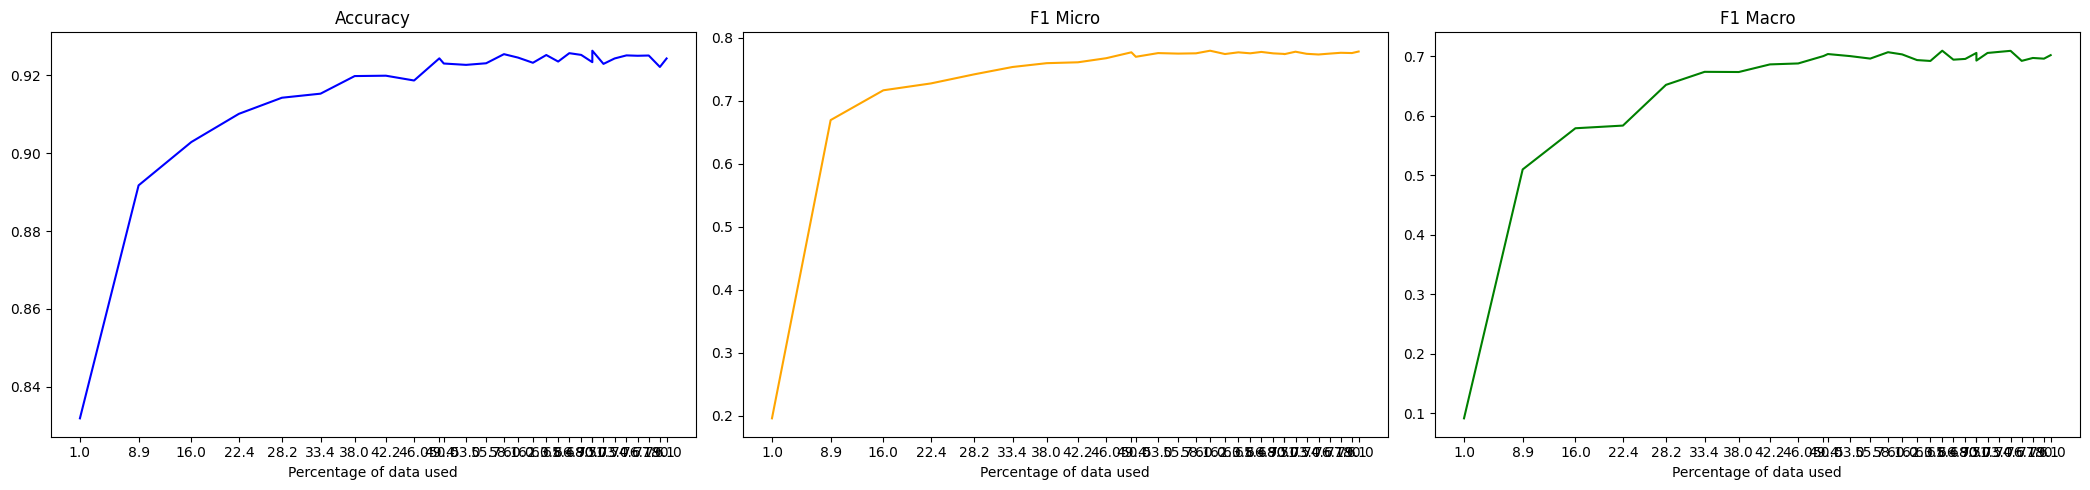

In [25]:
initial_train_size = int(0.01 * total_data)
active_learning(50, 0, 1)

TRIAL 1
Random seed: 50
label num 12
EPOCH 1 | LOSS: 12.44042950584775 | ACCURACY: 0.8481 | F1 MACRO: 0.0933 | F1 MICRO: 0.288
EPOCH 2 | LOSS: 8.972916398729597 | ACCURACY: 0.8675 | F1 MACRO: 0.1742 | F1 MICRO: 0.4492
EPOCH 3 | LOSS: 7.828327814737956 | ACCURACY: 0.8701 | F1 MACRO: 0.2214 | F1 MICRO: 0.4595
EPOCH 4 | LOSS: 7.511668523152669 | ACCURACY: 0.8791 | F1 MACRO: 0.2736 | F1 MICRO: 0.5126
EPOCH 5 | LOSS: 7.317902655828567 | ACCURACY: 0.886 | F1 MACRO: 0.3884 | F1 MICRO: 0.5749
EPOCH 6 | LOSS: 7.169459274836949 | ACCURACY: 0.8948 | F1 MACRO: 0.4383 | F1 MICRO: 0.6414
EPOCH 7 | LOSS: 7.069804464067731 | ACCURACY: 0.8968 | F1 MACRO: 0.4823 | F1 MICRO: 0.6529
EPOCH 8 | LOSS: 6.941515059698196 | ACCURACY: 0.8997 | F1 MACRO: 0.5238 | F1 MICRO: 0.6826
EPOCH 9 | LOSS: 6.827643780481248 | ACCURACY: 0.8982 | F1 MACRO: 0.5192 | F1 MICRO: 0.6801
EPOCH 10 | LOSS: 6.753925732203892 | ACCURACY: 0.8964 | F1 MACRO: 0.5105 | F1 MICRO: 0.6618
Training completed in 177.5128345489502 s
Iteration 13

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 10.80543281010219 | ACCURACY: 0.8692 | F1 MACRO: 0.2094 | F1 MICRO: 0.4872
EPOCH 2 | LOSS: 7.7393412590026855 | ACCURACY: 0.8801 | F1 MACRO: 0.2451 | F1 MICRO: 0.5384
EPOCH 3 | LOSS: 7.334435081481933 | ACCURACY: 0.8966 | F1 MACRO: 0.3878 | F1 MICRO: 0.6406
EPOCH 4 | LOSS: 7.158021627153669 | ACCURACY: 0.8995 | F1 MACRO: 0.4427 | F1 MICRO: 0.6536
EPOCH 5 | LOSS: 6.998018673488072 | ACCURACY: 0.8985 | F1 MACRO: 0.4493 | F1 MICRO: 0.6394
EPOCH 6 | LOSS: 6.884786115373884 | ACCURACY: 0.903 | F1 MACRO: 0.4645 | F1 MICRO: 0.6722
EPOCH 7 | LOSS: 6.717622457231794 | ACCURACY: 0.9039 | F1 MACRO: 0.5224 | F1 MICRO: 0.6862
EPOCH 8 | LOSS: 6.568095125470843 | ACCURACY: 0.9048 | F1 MACRO: 0.525 | F1 MICRO: 0.6953
EPOCH 9 | LOSS: 6.439081736973354 | ACCURACY: 0.9058 | F1 MACRO: 0.5615 | F1 MICRO: 0.6987
EPOCH 10 | LOSS: 6.3439482825143 | ACCURACY: 0.9042 | F1 MACRO: 0.5363 | F1 MICRO: 0.6898
Training completed in 200.96793699264526 s
Iteration 2238: ACCURACY 0.9058 | F1 MACRO 0.5615

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 9.795703003803888 | ACCURACY: 0.8775 | F1 MACRO: 0.2788 | F1 MICRO: 0.6007
EPOCH 2 | LOSS: 7.390634328126907 | ACCURACY: 0.8865 | F1 MACRO: 0.3212 | F1 MICRO: 0.5774
EPOCH 3 | LOSS: 7.129709939161937 | ACCURACY: 0.8988 | F1 MACRO: 0.4496 | F1 MICRO: 0.6641
EPOCH 4 | LOSS: 6.943704158067703 | ACCURACY: 0.9026 | F1 MACRO: 0.486 | F1 MICRO: 0.6862
EPOCH 5 | LOSS: 6.796391089757283 | ACCURACY: 0.9091 | F1 MACRO: 0.5206 | F1 MICRO: 0.7123
EPOCH 6 | LOSS: 6.632407029469808 | ACCURACY: 0.9068 | F1 MACRO: 0.5509 | F1 MICRO: 0.6974
EPOCH 7 | LOSS: 6.479518661896388 | ACCURACY: 0.9076 | F1 MACRO: 0.5471 | F1 MICRO: 0.6928
EPOCH 8 | LOSS: 6.359086602926254 | ACCURACY: 0.9043 | F1 MACRO: 0.5891 | F1 MICRO: 0.7227
EPOCH 9 | LOSS: 6.241703361272812 | ACCURACY: 0.9101 | F1 MACRO: 0.6034 | F1 MICRO: 0.7211
EPOCH 10 | LOSS: 6.131910194953282 | ACCURACY: 0.9083 | F1 MACRO: 0.62 | F1 MICRO: 0.7227
Training completed in 220.31590294837952 s
Iteration 3068: ACCURACY 0.9083 | F1 MACRO 0.62 |

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.989786154787305 | ACCURACY: 0.8879 | F1 MACRO: 0.3447 | F1 MICRO: 0.6226
EPOCH 2 | LOSS: 7.1782324079056865 | ACCURACY: 0.896 | F1 MACRO: 0.4261 | F1 MICRO: 0.6222
EPOCH 3 | LOSS: 6.94238762116768 | ACCURACY: 0.9061 | F1 MACRO: 0.49 | F1 MICRO: 0.6863
EPOCH 4 | LOSS: 6.759913276618635 | ACCURACY: 0.9086 | F1 MACRO: 0.5585 | F1 MICRO: 0.6935
EPOCH 5 | LOSS: 6.606609465370716 | ACCURACY: 0.9146 | F1 MACRO: 0.6233 | F1 MICRO: 0.7291
EPOCH 6 | LOSS: 6.434674652529434 | ACCURACY: 0.9149 | F1 MACRO: 0.666 | F1 MICRO: 0.7521
EPOCH 7 | LOSS: 6.318119015492184 | ACCURACY: 0.9152 | F1 MACRO: 0.6414 | F1 MICRO: 0.7353
EPOCH 8 | LOSS: 6.1864052154648475 | ACCURACY: 0.9148 | F1 MACRO: 0.639 | F1 MICRO: 0.7198
EPOCH 9 | LOSS: 6.077401866375561 | ACCURACY: 0.9168 | F1 MACRO: 0.6811 | F1 MICRO: 0.7503
EPOCH 10 | LOSS: 6.029158041510783 | ACCURACY: 0.9164 | F1 MACRO: 0.681 | F1 MICRO: 0.7465
Training completed in 254.65107202529907 s
Iteration 4487: ACCURACY 0.9149 | F1 MACRO 0.666 | 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 2.8918716430664064
Samples above threshold: 605
Acquired samples: 605
Sampling duration: 52.4026460647583 seconds
New train size: 5092


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.869103449583054 | ACCURACY: 0.8874 | F1 MACRO: 0.366 | F1 MICRO: 0.6405
EPOCH 2 | LOSS: 7.198796254396439 | ACCURACY: 0.8993 | F1 MACRO: 0.4652 | F1 MICRO: 0.6889
EPOCH 3 | LOSS: 6.968351137638092 | ACCURACY: 0.9103 | F1 MACRO: 0.5328 | F1 MICRO: 0.7129
EPOCH 4 | LOSS: 6.7767453789711 | ACCURACY: 0.9159 | F1 MACRO: 0.5843 | F1 MICRO: 0.725
EPOCH 5 | LOSS: 6.598459213972092 | ACCURACY: 0.9162 | F1 MACRO: 0.649 | F1 MICRO: 0.7487
EPOCH 6 | LOSS: 6.444644331932068 | ACCURACY: 0.9183 | F1 MACRO: 0.6586 | F1 MICRO: 0.7411
EPOCH 7 | LOSS: 6.302679312229157 | ACCURACY: 0.9161 | F1 MACRO: 0.682 | F1 MICRO: 0.7528
EPOCH 8 | LOSS: 6.17894613146782 | ACCURACY: 0.9191 | F1 MACRO: 0.6824 | F1 MICRO: 0.7426
EPOCH 9 | LOSS: 6.0755463421344755 | ACCURACY: 0.9193 | F1 MACRO: 0.6867 | F1 MICRO: 0.7602
EPOCH 10 | LOSS: 6.011316615343094 | ACCURACY: 0.9163 | F1 MACRO: 0.692 | F1 MICRO: 0.7571
Training completed in 272.5662817955017 s
Iteration 5092: ACCURACY 0.9193 | F1 MACRO 0.6867 | F1

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 2.480264663696289
Samples above threshold: 545
Acquired samples: 545
Sampling duration: 52.59514760971069 seconds
New train size: 5637
EPOCH 1 | LOSS: 8.692618627226755 | ACCURACY: 0.8893 | F1 MACRO: 0.3972 | F1 MICRO: 0.5988
EPOCH 2 | LOSS: 7.149024824078164 | ACCURACY: 0.9019 | F1 MACRO: 0.4884 | F1 MICRO: 0.6572
EPOCH 3 | LOSS: 6.908687768357523 | ACCURACY: 0.9118 | F1 MACRO: 0.6095 | F1 MICRO: 0.7371
EPOCH 4 | LOSS: 6.731226685341825 | ACCURACY: 0.9177 | F1 MACRO: 0.6284 | F1 MICRO: 0.7429
EPOCH 5 | LOSS: 6.568128639392638 | ACCURACY: 0.9179 | F1 MACRO: 0.6382 | F1 MICRO: 0.7447
EPOCH 6 | LOSS: 6.420793289548896 | ACCURACY: 0.9213 | F1 MACRO: 0.6767 | F1 MICRO: 0.7535
EPOCH 7 | LOSS: 6.29979554187046 | ACCURACY: 0.9198 | F1 MACRO: 0.6799 | F1 MICRO: 0.7634
EPOCH 8 | LOSS: 6.190616554088807 | ACCURACY: 0.922 | F1 MACRO: 0.676 | F1 MICRO: 0.7569
EPOCH 9 | LOSS: 6.093274132589276 | ACCURACY: 0.9206 | F1 MACRO: 0.6773 | F1 MICRO: 0.7501
EPOCH 10 | LO

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 6584
Threshold: 1.9902368783950806
Samples above threshold: 397
Acquired samples: 16
Sampling duration: 52.79894948005676 seconds
New train size: 6584


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.626284529861895 | ACCURACY: 0.8938 | F1 MACRO: 0.4188 | F1 MICRO: 0.6279
EPOCH 2 | LOSS: 7.1320148255061175 | ACCURACY: 0.9061 | F1 MACRO: 0.5346 | F1 MICRO: 0.7208
EPOCH 3 | LOSS: 6.8909839565314135 | ACCURACY: 0.9148 | F1 MACRO: 0.5979 | F1 MICRO: 0.7159
EPOCH 4 | LOSS: 6.7014769257851015 | ACCURACY: 0.9211 | F1 MACRO: 0.6373 | F1 MICRO: 0.7413
EPOCH 5 | LOSS: 6.528612122952359 | ACCURACY: 0.9164 | F1 MACRO: 0.6391 | F1 MICRO: 0.72
EPOCH 6 | LOSS: 6.391515190161548 | ACCURACY: 0.9241 | F1 MACRO: 0.6853 | F1 MICRO: 0.7643
EPOCH 7 | LOSS: 6.2539875252732955 | ACCURACY: 0.9255 | F1 MACRO: 0.6983 | F1 MICRO: 0.7707
EPOCH 8 | LOSS: 6.159573652211902 | ACCURACY: 0.9234 | F1 MACRO: 0.688 | F1 MICRO: 0.7626
EPOCH 9 | LOSS: 6.070076664674629 | ACCURACY: 0.921 | F1 MACRO: 0.6969 | F1 MICRO: 0.7602
EPOCH 10 | LOSS: 5.99505196265804 | ACCURACY: 0.9237 | F1 MACRO: 0.7003 | F1 MICRO: 0.763
Training completed in 308.43424582481384 s
Iteration 6584: ACCURACY 0.9255 | F1 MACRO 0.698

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.482199335098267 | ACCURACY: 0.8952 | F1 MACRO: 0.4736 | F1 MICRO: 0.6503
EPOCH 2 | LOSS: 7.085058266466314 | ACCURACY: 0.9143 | F1 MACRO: 0.572 | F1 MICRO: 0.7314
EPOCH 3 | LOSS: 6.847949329289523 | ACCURACY: 0.9195 | F1 MACRO: 0.626 | F1 MICRO: 0.7425
EPOCH 4 | LOSS: 6.66170784776861 | ACCURACY: 0.9236 | F1 MACRO: 0.6633 | F1 MICRO: 0.7611
EPOCH 5 | LOSS: 6.513934876702049 | ACCURACY: 0.9229 | F1 MACRO: 0.6827 | F1 MICRO: 0.7586
EPOCH 6 | LOSS: 6.376538747007197 | ACCURACY: 0.9237 | F1 MACRO: 0.695 | F1 MICRO: 0.7689
EPOCH 7 | LOSS: 6.250105370174754 | ACCURACY: 0.9243 | F1 MACRO: 0.6851 | F1 MICRO: 0.7711
EPOCH 8 | LOSS: 6.129080159013921 | ACCURACY: 0.9253 | F1 MACRO: 0.7015 | F1 MICRO: 0.7771
EPOCH 9 | LOSS: 6.045669516650113 | ACCURACY: 0.9226 | F1 MACRO: 0.6967 | F1 MICRO: 0.77
EPOCH 10 | LOSS: 5.987602320584384 | ACCURACY: 0.9222 | F1 MACRO: 0.6985 | F1 MICRO: 0.7691
Training completed in 320.8658185005188 s
Iteration 6980: ACCURACY 0.9253 | F1 MACRO 0.7015 | F

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.494806611537934 | ACCURACY: 0.8967 | F1 MACRO: 0.4414 | F1 MICRO: 0.6484
EPOCH 2 | LOSS: 7.090844464302063 | ACCURACY: 0.9137 | F1 MACRO: 0.5768 | F1 MICRO: 0.7212
EPOCH 3 | LOSS: 6.844537798563639 | ACCURACY: 0.9214 | F1 MACRO: 0.6444 | F1 MICRO: 0.7498
EPOCH 4 | LOSS: 6.666152803103129 | ACCURACY: 0.9199 | F1 MACRO: 0.6274 | F1 MICRO: 0.7355
EPOCH 5 | LOSS: 6.510452095667521 | ACCURACY: 0.9236 | F1 MACRO: 0.6813 | F1 MICRO: 0.7681
EPOCH 6 | LOSS: 6.38320807615916 | ACCURACY: 0.9244 | F1 MACRO: 0.6899 | F1 MICRO: 0.7643
EPOCH 7 | LOSS: 6.263976510365804 | ACCURACY: 0.9213 | F1 MACRO: 0.6795 | F1 MICRO: 0.7518
EPOCH 8 | LOSS: 6.1684025208155315 | ACCURACY: 0.9212 | F1 MACRO: 0.6888 | F1 MICRO: 0.7665
EPOCH 9 | LOSS: 6.069311948617299 | ACCURACY: 0.9234 | F1 MACRO: 0.6986 | F1 MICRO: 0.7678
EPOCH 10 | LOSS: 6.016475284099579 | ACCURACY: 0.924 | F1 MACRO: 0.6988 | F1 MICRO: 0.7721
Training completed in 335.0100607872009 s
Iteration 7656: ACCURACY 0.924 | F1 MACRO 0.6988

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 7901
Threshold: 1.6656213998794556
Samples above threshold: 288
Acquired samples: 245
Sampling duration: 52.42831802368164 seconds
New train size: 7901


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.467280907015647 | ACCURACY: 0.8958 | F1 MACRO: 0.444 | F1 MICRO: 0.622
EPOCH 2 | LOSS: 7.068190255472737 | ACCURACY: 0.9154 | F1 MACRO: 0.5735 | F1 MICRO: 0.7304
EPOCH 3 | LOSS: 6.831215112440048 | ACCURACY: 0.921 | F1 MACRO: 0.6417 | F1 MICRO: 0.7559
EPOCH 4 | LOSS: 6.652939431128964 | ACCURACY: 0.9226 | F1 MACRO: 0.6692 | F1 MICRO: 0.7617
EPOCH 5 | LOSS: 6.5036858550963865 | ACCURACY: 0.9232 | F1 MACRO: 0.6863 | F1 MICRO: 0.7717
EPOCH 6 | LOSS: 6.36968570370828 | ACCURACY: 0.9216 | F1 MACRO: 0.6632 | F1 MICRO: 0.7435
EPOCH 7 | LOSS: 6.25516446944206 | ACCURACY: 0.9245 | F1 MACRO: 0.6852 | F1 MICRO: 0.7638
EPOCH 8 | LOSS: 6.164098012831904 | ACCURACY: 0.9235 | F1 MACRO: 0.698 | F1 MICRO: 0.7668
EPOCH 9 | LOSS: 6.090951485018576 | ACCURACY: 0.923 | F1 MACRO: 0.6826 | F1 MICRO: 0.7616
EPOCH 10 | LOSS: 6.025145423027777 | ACCURACY: 0.9234 | F1 MACRO: 0.6938 | F1 MICRO: 0.7658
Training completed in 342.2705307006836 s
Iteration 7901: ACCURACY 0.9232 | F1 MACRO 0.6863 | F

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.430784672498703 | ACCURACY: 0.8983 | F1 MACRO: 0.4699 | F1 MICRO: 0.6513
EPOCH 2 | LOSS: 7.07353674992919 | ACCURACY: 0.9143 | F1 MACRO: 0.5873 | F1 MICRO: 0.7404
EPOCH 3 | LOSS: 6.8385435454547405 | ACCURACY: 0.9198 | F1 MACRO: 0.6479 | F1 MICRO: 0.7521
EPOCH 4 | LOSS: 6.655853286385536 | ACCURACY: 0.9227 | F1 MACRO: 0.6656 | F1 MICRO: 0.762
EPOCH 5 | LOSS: 6.511421158909798 | ACCURACY: 0.9227 | F1 MACRO: 0.6775 | F1 MICRO: 0.7723
EPOCH 6 | LOSS: 6.381384335458279 | ACCURACY: 0.9221 | F1 MACRO: 0.6836 | F1 MICRO: 0.7495
EPOCH 7 | LOSS: 6.2694628313183784 | ACCURACY: 0.9231 | F1 MACRO: 0.6909 | F1 MICRO: 0.763
EPOCH 8 | LOSS: 6.17384560033679 | ACCURACY: 0.9237 | F1 MACRO: 0.6893 | F1 MICRO: 0.7705
EPOCH 9 | LOSS: 6.094481684267521 | ACCURACY: 0.9254 | F1 MACRO: 0.6918 | F1 MICRO: 0.7715
EPOCH 10 | LOSS: 6.0372967682778835 | ACCURACY: 0.9238 | F1 MACRO: 0.6887 | F1 MICRO: 0.7626
Training completed in 348.287495136261 s
Iteration 8165: ACCURACY 0.9227 | F1 MACRO 0.6775

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.6052683591842651
Samples above threshold: 214
Acquired samples: 214
Sampling duration: 52.29386115074158 seconds
New train size: 8616
EPOCH 1 | LOSS: 8.42606324089898 | ACCURACY: 0.8968 | F1 MACRO: 0.445 | F1 MICRO: 0.6293
EPOCH 2 | LOSS: 7.05651866418344 | ACCURACY: 0.9101 | F1 MACRO: 0.5228 | F1 MICRO: 0.6827
EPOCH 3 | LOSS: 6.831238273338036 | ACCURACY: 0.9214 | F1 MACRO: 0.6568 | F1 MICRO: 0.763
EPOCH 4 | LOSS: 6.659597944330286 | ACCURACY: 0.9234 | F1 MACRO: 0.6681 | F1 MICRO: 0.7535
EPOCH 5 | LOSS: 6.52400031266389 | ACCURACY: 0.9249 | F1 MACRO: 0.6752 | F1 MICRO: 0.7643
EPOCH 6 | LOSS: 6.399530329527678 | ACCURACY: 0.9258 | F1 MACRO: 0.697 | F1 MICRO: 0.7707
EPOCH 7 | LOSS: 6.286981593237983 | ACCURACY: 0.9236 | F1 MACRO: 0.6886 | F1 MICRO: 0.7709
EPOCH 8 | LOSS: 6.2075864897833934 | ACCURACY: 0.9256 | F1 MACRO: 0.695 | F1 MICRO: 0.7751
EPOCH 9 | LOSS: 6.1174198963024 | ACCURACY: 0.9244 | F1 MACRO: 0.7 | F1 MICRO: 0.7717
EPOCH 10 | LOSS: 6.0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.5870003700256348
Samples above threshold: 192
Acquired samples: 200
Sampling duration: 52.19572901725769 seconds
New train size: 8816
EPOCH 1 | LOSS: 8.403122141741324 | ACCURACY: 0.9024 | F1 MACRO: 0.494 | F1 MICRO: 0.6712
EPOCH 2 | LOSS: 7.060813986736795 | ACCURACY: 0.9136 | F1 MACRO: 0.5357 | F1 MICRO: 0.707
EPOCH 3 | LOSS: 6.835727249366649 | ACCURACY: 0.9212 | F1 MACRO: 0.6422 | F1 MICRO: 0.75
EPOCH 4 | LOSS: 6.660969675451085 | ACCURACY: 0.9241 | F1 MACRO: 0.6617 | F1 MICRO: 0.7567
EPOCH 5 | LOSS: 6.52606227086938 | ACCURACY: 0.9248 | F1 MACRO: 0.6806 | F1 MICRO: 0.7709
EPOCH 6 | LOSS: 6.39479012420212 | ACCURACY: 0.9225 | F1 MACRO: 0.703 | F1 MICRO: 0.7715
EPOCH 7 | LOSS: 6.291025096091671 | ACCURACY: 0.921 | F1 MACRO: 0.697 | F1 MICRO: 0.7656
EPOCH 8 | LOSS: 6.197589114092398 | ACCURACY: 0.924 | F1 MACRO: 0.6912 | F1 MICRO: 0.7701
EPOCH 9 | LOSS: 6.137638133505116 | ACCURACY: 0.9244 | F1 MACRO: 0.6985 | F1 MICRO: 0.771
EPOCH 10 | LOSS: 6.0

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Nearest checkpoint: 9218
Threshold: 1.5695101022720337
Samples above threshold: 172
Acquired samples: 200
Sampling duration: 52.18362522125244 seconds
New train size: 9016
EPOCH 1 | LOSS: 8.397630836946744 | ACCURACY: 0.8994 | F1 MACRO: 0.4891 | F1 MICRO: 0.6507
EPOCH 2 | LOSS: 7.044599587190236 | ACCURACY: 0.9163 | F1 MACRO: 0.5814 | F1 MICRO: 0.7248
EPOCH 3 | LOSS: 6.8212300834926305 | ACCURACY: 0.9213 | F1 MACRO: 0.636 | F1 MICRO: 0.7604
EPOCH 4 | LOSS: 6.650777769426927 | ACCURACY: 0.9243 | F1 MACRO: 0.6708 | F1 MICRO: 0.7595
EPOCH 5 | LOSS: 6.524786580538919 | ACCURACY: 0.9258 | F1 MACRO: 0.6754 | F1 MICRO: 0.7639
EPOCH 6 | LOSS: 6.39651993825926 | ACCURACY: 0.9264 | F1 MACRO: 0.6862 | F1 MICRO: 0.7707
EPOCH 7 | LOSS: 6.286093390579765 | ACCURACY: 0.9252 | F1 MACRO: 0.6995 | F1 MICRO: 0.7675
EPOCH 8 | LOSS: 6.194393557014195 | ACCURACY: 0.9235 | F1 MACRO: 0.6987 | F1 MICRO: 0.7709
EPOCH 9 | LOSS: 6.128296781093516 | ACCURACY: 0.9248 | F1 MACRO: 0.7058 | F1 MICRO: 0.775
EPOCH 10 | 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.327014149846258 | ACCURACY: 0.8933 | F1 MACRO: 0.4181 | F1 MICRO: 0.5995
EPOCH 2 | LOSS: 7.028531000420854 | ACCURACY: 0.9135 | F1 MACRO: 0.5991 | F1 MICRO: 0.7096
EPOCH 3 | LOSS: 6.805057967031324 | ACCURACY: 0.9221 | F1 MACRO: 0.6517 | F1 MICRO: 0.7543
EPOCH 4 | LOSS: 6.642765196594032 | ACCURACY: 0.9232 | F1 MACRO: 0.6694 | F1 MICRO: 0.7509
EPOCH 5 | LOSS: 6.504262453800923 | ACCURACY: 0.9257 | F1 MACRO: 0.6872 | F1 MICRO: 0.773
EPOCH 6 | LOSS: 6.392573163316056 | ACCURACY: 0.9269 | F1 MACRO: 0.7026 | F1 MICRO: 0.7775
EPOCH 7 | LOSS: 6.285808424691896 | ACCURACY: 0.9232 | F1 MACRO: 0.7025 | F1 MICRO: 0.7752
EPOCH 8 | LOSS: 6.208266100367984 | ACCURACY: 0.9244 | F1 MACRO: 0.6985 | F1 MICRO: 0.7756
EPOCH 9 | LOSS: 6.125042296744682 | ACCURACY: 0.9233 | F1 MACRO: 0.6924 | F1 MICRO: 0.7645
EPOCH 10 | LOSS: 6.073153621441609 | ACCURACY: 0.9251 | F1 MACRO: 0.6982 | F1 MICRO: 0.7672
Training completed in 380.06295108795166 s
Iteration 9418: ACCURACY 0.9269 | F1 MACRO 0.70

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.294210591873565 | ACCURACY: 0.9021 | F1 MACRO: 0.5299 | F1 MICRO: 0.6946
EPOCH 2 | LOSS: 7.008565119334629 | ACCURACY: 0.917 | F1 MACRO: 0.5736 | F1 MICRO: 0.7266
EPOCH 3 | LOSS: 6.797770438256202 | ACCURACY: 0.9213 | F1 MACRO: 0.6266 | F1 MICRO: 0.7462
EPOCH 4 | LOSS: 6.644630373298348 | ACCURACY: 0.9239 | F1 MACRO: 0.6588 | F1 MICRO: 0.7544
EPOCH 5 | LOSS: 6.520346387640222 | ACCURACY: 0.9234 | F1 MACRO: 0.6565 | F1 MICRO: 0.7487
EPOCH 6 | LOSS: 6.405621531721834 | ACCURACY: 0.9242 | F1 MACRO: 0.6737 | F1 MICRO: 0.7622
EPOCH 7 | LOSS: 6.308415676092173 | ACCURACY: 0.921 | F1 MACRO: 0.698 | F1 MICRO: 0.7675
EPOCH 8 | LOSS: 6.224523178942792 | ACCURACY: 0.9241 | F1 MACRO: 0.7006 | F1 MICRO: 0.7703
EPOCH 9 | LOSS: 6.139784936781053 | ACCURACY: 0.925 | F1 MACRO: 0.7051 | F1 MICRO: 0.7717
EPOCH 10 | LOSS: 6.086679303800905 | ACCURACY: 0.9259 | F1 MACRO: 0.7134 | F1 MICRO: 0.7755
Training completed in 396.40075969696045 s
Iteration 9818: ACCURACY 0.9259 | F1 MACRO 0.7134 

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


EPOCH 1 | LOSS: 8.270946577823523 | ACCURACY: 0.9033 | F1 MACRO: 0.4905 | F1 MICRO: 0.666
EPOCH 2 | LOSS: 6.989959901751894 | ACCURACY: 0.9139 | F1 MACRO: 0.551 | F1 MICRO: 0.704
EPOCH 3 | LOSS: 6.793953008362741 | ACCURACY: 0.923 | F1 MACRO: 0.6557 | F1 MICRO: 0.7583
EPOCH 4 | LOSS: 6.651020827437892 | ACCURACY: 0.9236 | F1 MACRO: 0.6686 | F1 MICRO: 0.7678
EPOCH 5 | LOSS: 6.524470141439727 | ACCURACY: 0.9244 | F1 MACRO: 0.7016 | F1 MICRO: 0.7782
EPOCH 6 | LOSS: 6.412023073254209 | ACCURACY: 0.9256 | F1 MACRO: 0.7005 | F1 MICRO: 0.776
EPOCH 7 | LOSS: 6.309419314066569 | ACCURACY: 0.9255 | F1 MACRO: 0.6956 | F1 MICRO: 0.7764
EPOCH 8 | LOSS: 6.235104384566799 | ACCURACY: 0.9236 | F1 MACRO: 0.6922 | F1 MICRO: 0.762
EPOCH 9 | LOSS: 6.1658489285093365 | ACCURACY: 0.9263 | F1 MACRO: 0.6922 | F1 MICRO: 0.7713
EPOCH 10 | LOSS: 6.106586462078672 | ACCURACY: 0.9259 | F1 MACRO: 0.7128 | F1 MICRO: 0.7781
Training completed in 409.28434205055237 s
Iteration 10535: ACCURACY 0.9244 | F1 MACRO 0.7016 

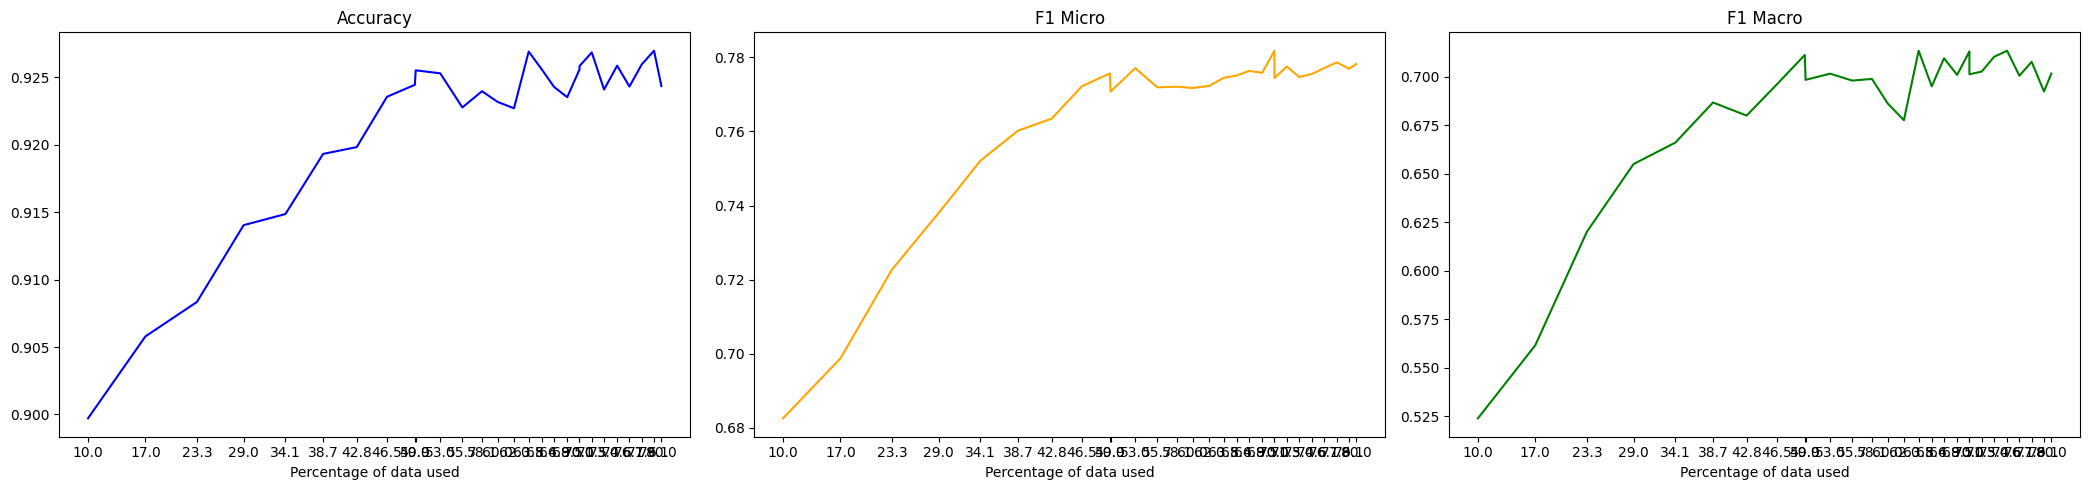

In [26]:
initial_train_size = int(0.1 * total_data)
active_learning(50, 0, 10)